In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
!pip install opencv-python

In [14]:
!pip install "tensorflow>=1.7.0"
!pip install tensorflow-addons
!pip install tensorflow-hub

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.3 MB/s eta 0:00:00
tensorflow version: 2.15.0


In [17]:
!pip install -U git+https://github.com/leondgarse/keras_cv_attention_models

  Cloning https://github.com/leondgarse/keras_cv_attention_models to /tmp/pip-req-build-lposvw1r
  Running command git clone --filter=blob:none --quiet https://github.com/leondgarse/keras_cv_attention_models /tmp/pip-req-build-lposvw1r
  Resolved https://github.com/leondgarse/keras_cv_attention_models to commit 4e9156520cfd700bb78d491983e39160647f6b19
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.2 MB/s eta 0:00:00
  Created wheel for keras-cv-attention-models: filename=keras_cv_attention_models-1.4.2-py3-none-any.whl size=798347 sha256=cca32d6906e159192ff5f6b3c7027c0b5eb82915a76b44f26b2ad3f0c52e37f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-nbtnonyz/wheels/16/98/1e/847241ad48bd552bd921ea08001f22a1ecab471036f6b09bb4
Successfully built keras-cv-attention-models


>>>> Load pretrained from: /root/.keras/models/maxvit_tiny_224_imagenet.h5


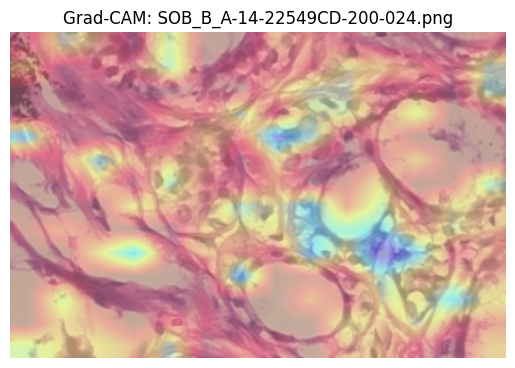

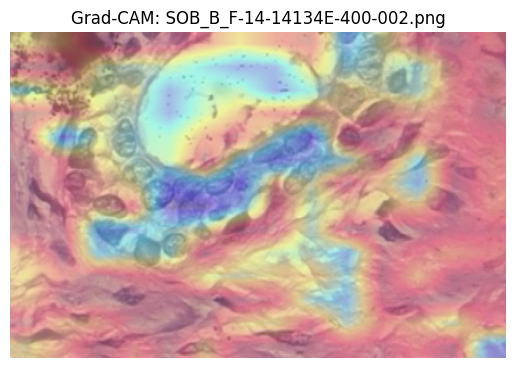

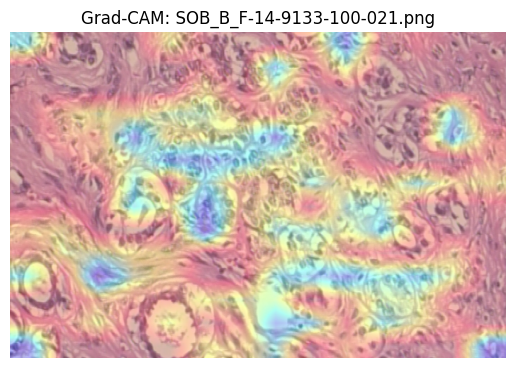

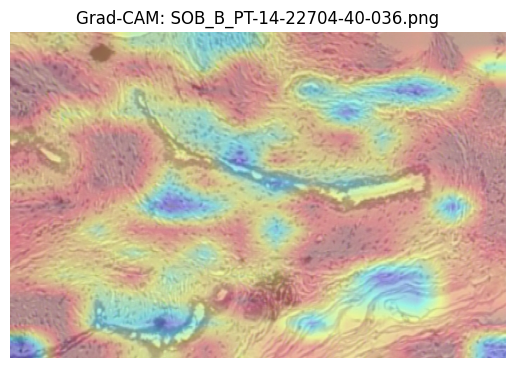

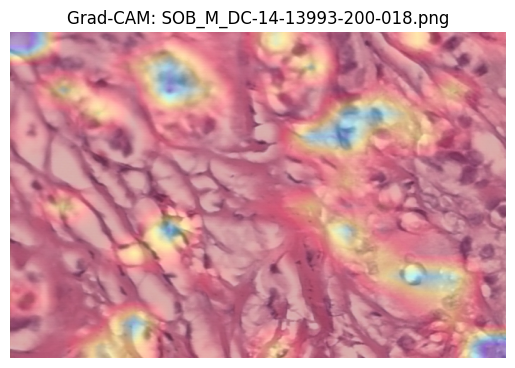

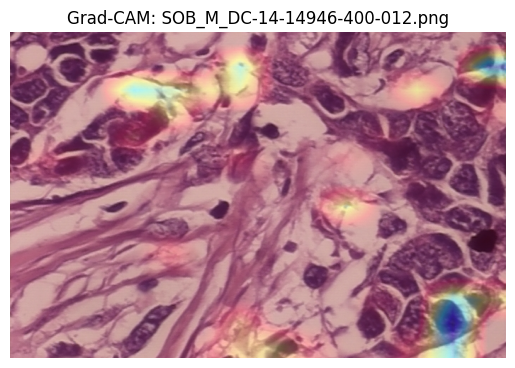

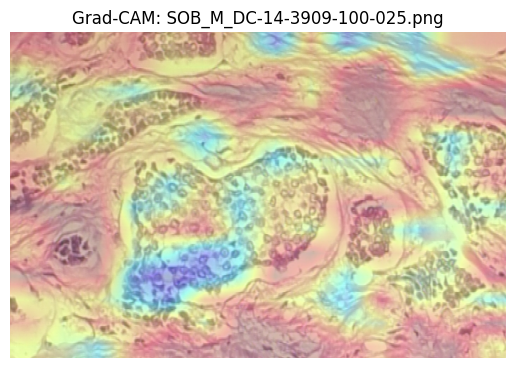

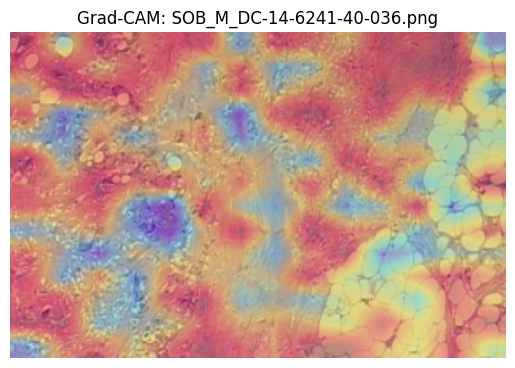

In [19]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from keras_cv_attention_models import maxvit

def get_grad_cam(model, img_path, class_index, layer_name):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # Resize to match model input size
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)

    grad_model = tf.keras.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img)
        class_output = predictions[:, class_index]

    grads = tape.gradient(class_output, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay_img = heatmap * alpha + img
    overlay_img = overlay_img / np.max(overlay_img) * 255  # normalize
    return overlay_img

model = maxvit.MaxViT_Tiny(input_shape=(224, 224, 3), pretrained="imagenet")
# mm.summary()

# Folder path containing images
folder_path = '/content/drive/MyDrive/Breast Cancer Project/img_early'

# Choose the class index for which you want to visualize the Grad-CAM
class_index = 292  # Example class index for 'tiger_cat'

# Choose the layer for which you want to compute the Grad-CAM
layer_name = 'stack_3_block_5/grid_ffn_output'  # Output Layer

# Output folder path for saving Grad-CAM visualizations
output_folder = '/content/drive/MyDrive/Breast Cancer Project/grad_cam_results'
os.makedirs(output_folder, exist_ok=True)

# Iterate through images in the folder and generate Grad-CAM visualizations
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    heatmap = get_grad_cam(model, img_path, class_index, layer_name)

    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image
    overlaid_img = overlay_heatmap(img, heatmap)

    # Plot the overlaid image
    plt.imshow(overlaid_img.astype(np.uint8))
    plt.axis('off')
    plt.title(f'Grad-CAM: {img_name}')
    plt.show()

In [20]:
classes = ['DC', 'A', 'PC', 'PT', 'TA', 'MC', 'F', 'LC']
class_indices = {cls: idx for idx, cls in enumerate(classes)}